<center><h1>CNN 多通道情感分析</h1></center>

一个有三个通道，分别是word embedding，POS 标签 embedding, 词的情感极性强度embedding

In [28]:
import keras 
from  os.path import join
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, Lambda,Input
from keras.layers import Embedding
from keras.layers import Convolution1D
from keras.datasets import imdb
from keras import backend as K
from keras.layers import Convolution1D, GlobalMaxPooling1D,Convolution2D,Merge,merge
from keras.utils import np_utils
from keras.models import Model
import nltk
from nltk.tag import pos_tag

## POS当作一个通道。


Tag word 的方法： http://www.nltk.org/book/ch05.html

In [13]:
file_names = ['stsa.fine.test','stsa.fine.train','stsa.fine.dev']
file_path = '/home/bruce/data/sentiment/citai_process'
def read_file(fname=''):
    with open(join(file_path,fname)) as fr:
        lines = fr.readlines()
    lines = [line.strip().lower() for line in lines]
    lables = [int(line[0:1]) for line in lines]
    words = [line[2:].split() for line in lines]
    return words,lables       
train_X,train_y = read_file(fname='stsa.fine.train')
test_X,test_y = read_file(fname='stsa.fine.test')
dev_X,dev_y = read_file(fname='stsa.fine.dev')
print(len(train_X))
print(len(test_X))
print(len(dev_X))
print(train_X[0:2])
print(train_y[0:2])


8544
2210
1101
[['a', 'stirring', ',', 'funny', 'and', 'finally', 'transport', 're-imagining', 'of', 'beauty', 'and', 'the', 'beast', 'and', '1930s', 'horror', 'film'], ['apparently', 'reassemble', 'from', 'the', 'cutting-room', 'floor', 'of', 'any', 'give', 'daytime', 'soap', '.']]
[4, 1]


In [14]:
def tag_sentence(X=[]):
    tag_X=[]
    for line in X:
        word_tag = pos_tag(line,tagset='universal')
        tag = [i[1] for i in word_tag]
        tag_X.append(tag)
    return tag_X
train_tag_X = tag_sentence(X=train_X)
dev_tag_X = tag_sentence(X=dev_X)
print(train_X[0])
print(train_tag_X[0])

## 情感极性当作一个通道。


#### 读取情感强度文件，构建字典

In [16]:
senti_file = '/home/bruce/data/sentiment/sentiment_diction/wordwithStrength.txt'
def construct_senti_dict(senti_file=''):
    with open(senti_file) as fr:
        lines = fr.readlines()
    lines = [line.strip().split() for line in lines]
    lines = [(i[0],float(i[1])) for i in lines]
    return dict(lines)
sentiment_dict=construct_senti_dict(senti_file)
print('sentiment number =',len(sentiment_dict))

sentiment number = 18540


#### 构建情感极性强度通道

In [17]:
def sentiment_strength(X=[],sentiment_dict=sentiment_dict):
    sentiment_X = [[sentiment_dict[w] if w in sentiment_dict else 0 for w in line ]for line in X]
    sentiment_X = [[ str(int(val*10)) if val <=0 else  '+'+str(int(val*10)) for val in line] for line in sentiment_X]
    return sentiment_X
train_sentiment_X = sentiment_strength(X=train_X,sentiment_dict=sentiment_dict)
dev_sentiment_X = sentiment_strength(X=dev_X,sentiment_dict=sentiment_dict)

assert len(train_sentiment_X) == len(train_X) 
print(train_sentiment_X[0:5])
print(train_X[0:5])    
print(train_y[0:5])


[['0', '+4', '0', '0', '0', '0', '0', '0', '0', '+2', '0', '0', '-5', '0', '0', '-2', '0'], ['+5', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], ['0', '-5', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '+6', '-2', '0', '+2', '0', '0', '-3', '0', '0', '0', '-5', '0', '0', '0', '0', '0', '0', '0', '-2', '0', '0'], ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], ['0', '0', '0', '+5', '-2', '0', '+2', '+3', '0', '0', '0', '0', '0', '0', '-3', '0', '+2', '0', '0', '0']]
[['a', 'stirring', ',', 'funny', 'and', 'finally', 'transport', 're-imagining', 'of', 'beauty', 'and', 'the', 'beast', 'and', '1930s', 'horror', 'film'], ['apparently', 'reassemble', 'from', 'the', 'cutting-room', 'floor', 'of', 'any', 'give', 'daytime', 'soap', '.'], ['they', 'presume', 'their', 'audience', 'wo', "n't", 'sit', 'still', 'for', 'a', 'sociology', 'lesson', ',', 'however', 'entertainingly', 'present', ',', 'so', 'they', 'trot', 'out', 'the', 'conventional', 'science-fiction', 'eleme

## 否定词。

1.资料：http://web.stanford.edu/~cgpotts/papers/potts-salt20-negation.pdf

2.Negation handing in NLP  http://stackoverflow.com/questions/28720174/negation-handling-in-nlp

#### 数据预处理

In [18]:
def token_to_index(datas=[]):
    word_index={}
    count=1
    for data in datas:
        for list_ in data:
            for w in list_:
                if w not in word_index:
                    word_index[w] = count
                    count = count + 1
    print('leng of word_index =',len(word_index))
    for i in range(len(datas)):
        datas[i] = [[ word_index[w] for w in line ] for line in datas[i]] 
    return datas,word_index
X,word_index = token_to_index(datas=[train_X,dev_X,train_sentiment_X,train_tag_X,dev_sentiment_X,dev_tag_X])
train_X,dev_X,train_sentiment_X,train_tag_X,dev_sentiment_X,dev_tag_X = X

print('length of dict_index = ',len(word_index))


leng of word_index = 14525
length of dict_index =  14525


In [19]:
print(train_sentiment_X[0:2])
print(train_X[0:2])    
print(train_y[0:2])

[[14498, 14499, 14498, 14498, 14498, 14498, 14498, 14498, 14498, 14500, 14498, 14498, 14501, 14498, 14498, 14502, 14498], [14503, 14498, 14498, 14498, 14498, 14498, 14498, 14498, 14498, 14498, 14498, 14498]]
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 5, 11, 12, 5, 13, 14, 15], [16, 17, 18, 11, 19, 20, 9, 21, 22, 23, 24, 25]]
[4, 1]


## 构建模型

#### 模型参数

In [56]:
max_len = 36
batch_size=32

max_features= 14526
embedding_dims=200

nb_filter = 150
filter_length = 2
dense1_hindden = 150*2
nb_classes = 5

## 错误记录

1.输入的变量和后面同名

In [57]:
print('Build model...')
input1 = Input(shape=(max_len,), dtype='int32', name='main_input1')
input2 = Input(shape=(max_len,), dtype='int32', name='main_input2')
input3 = Input(shape=(max_len,), dtype='int32', name='main_input3')

embedding = Embedding(output_dim=embedding_dims, input_dim=max_features)
embedding1 = embedding(input1)
embedding2 = embedding(input2)
embedding3 = embedding(input3)

conv1 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length,
                        border_mode = 'valid',
                        activation='relu',
                        subsample_length = 1
                       )(embedding1)
conv2 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length,
                        border_mode = 'valid',
                        activation='relu',
                        subsample_length = 1
                       )(embedding2)
conv3 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length,
                        border_mode = 'valid',
                        activation='relu',
                        subsample_length = 1
                       )(embedding3)

conv11 = GlobalMaxPooling1D()(conv1)
conv12 = GlobalMaxPooling1D()(conv2)
conv13 = GlobalMaxPooling1D()(conv3)
merged_vector = merge([conv11,conv12,conv13], mode='concat')


dens1 = Dense(dense1_hindden)(merged_vector)
dens1 = Dropout(0.2)(dens1)
dens1 = Activation('relu')(dens1)

dens2 = Dense(nb_classes)(dens1)
output = Activation('softmax')(dens2)
model = Model(input=[input1,input2,input3],output=output)

print('finish build model')
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Build model...
Join.0
finish build model


## 模型图

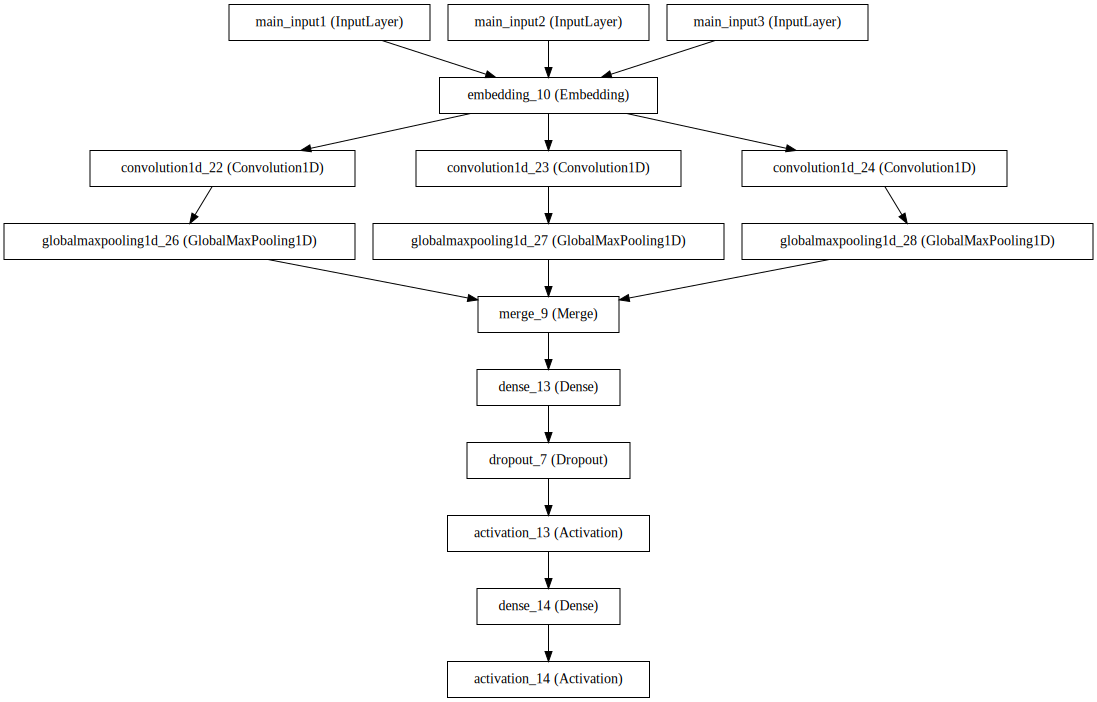

In [58]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## 模型输入

In [59]:
print(type(train_y[0]))
train_y_model = np_utils.to_categorical(train_y, nb_classes)
dev_y_model = np_utils.to_categorical(dev_y, nb_classes)
train_X_model = sequence.pad_sequences(train_X, maxlen=max_len)
dev_X_model = sequence.pad_sequences(dev_X, maxlen=max_len)
train_sentiment_X_model = sequence.pad_sequences(train_sentiment_X,maxlen=max_len)
train_tag_X_model= sequence.pad_sequences(train_tag_X,maxlen=max_len)
dev_sentiment_X_model = sequence.pad_sequences(dev_sentiment_X,maxlen=max_len)
dev_tag_X_model = sequence.pad_sequences(dev_tag_X,maxlen=max_len)


<class 'int'>


In [60]:
def my_generator(X1=None,X2=None,X3=None,y=None):
    i = 0
    max_i = int(len(X1)/batch_size)
    while True:
        i = i % max_i
        x1_batch = X1[i*batch_size:(i+1)*batch_size]
        x2_batch = X2[i*batch_size:(i+1)*batch_size]
        x3_batch = X3[i*batch_size:(i+1)*batch_size]
        y_batch = y[i*batch_size:(i+1)*batch_size]
        yield ([x1_batch,x2_batch,x3_batch],y_batch)
        i = i + 1
        

## 训练模型

In [ ]:
model.fit_generator(my_generator(train_X_model,train_sentiment_X_model,train_tag_X_model,train_y_model),samples_per_epoch = 32*100,nb_epoch=100,verbose=1,validation_data=([dev_X_model,dev_sentiment_X_model,dev_tag_X_model],dev_y_model))

Epoch 1/100
3200/3200 [==============================] - 334s - loss: 1.5742 - acc: 0.2650 - val_loss: 1.5627 - val_acc: 0.2598
Epoch 2/100
3200/3200 [==============================] - 334s - loss: 1.5498 - acc: 0.2972 - val_loss: 1.5499 - val_acc: 0.3124
Epoch 3/100
3200/3200 [==============================] - 334s - loss: 1.5352 - acc: 0.3137 - val_loss: 1.5339 - val_acc: 0.3152
Epoch 4/100
3200/3200 [==============================] - 334s - loss: 1.5132 - acc: 0.3184 - val_loss: 1.5171 - val_acc: 0.3233
Epoch 5/100
3200/3200 [==============================] - 334s - loss: 1.4971 - acc: 0.3325 - val_loss: 1.5003 - val_acc: 0.3261
Epoch 6/100
3200/3200 [==============================] - 334s - loss: 1.4634 - acc: 0.3466 - val_loss: 1.4700 - val_acc: 0.3397
Epoch 7/100
3200/3200 [==============================] - 333s - loss: 1.4384 - acc: 0.3625 - val_loss: 1.4501 - val_acc: 0.3433
Epoch 8/100
3200/3200 [==============================] - 334s - loss: 1.4194 - acc: 0.3750 - val_loss: 1

## 实验结果 

|time            |max_len      | batch_size   |  max_features | embedding_dims | nb_filter | filter_length | dense1_hindden |val_acc |
| -             |-          |-          |-          |-           |-       |-         | -          |-     | 
| 2016-11-23 14：20  |36          |32         | 14526       |   200       |  150    |     2    |       300   | 0.4015|
